## Implementing Movie Sentiment Analysis using LSTMs and Word2vec Word Embeddings

## Learning Objectives

At the end of the experiment, you will be able to

* build a Deep Neural Network for Sentiment Classification
* learn Word Embedding : while training the network and using Word2Vec
* understand cell structure of LSTMs
* implement unidirectional and bidirectional LSTMs

## Recurrent neural network (RNN)

RNN is a type of neural network that is proven to work well with sequence data. Since text is actually a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. Here, we will use an LSTM (Long Short Term Memory network) which is a variant of RNN, to solve a movie reviews based sentiment classification problem.

An LSTM unit consists of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classification based on time series data and deal well with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs

<img style="-webkit-user-select: none;margin: auto;" src="https://miro.medium.com/max/1302/1*yr0820z7YNRcDCWGisLC4g.png" width="450" height="250">


<img style="-webkit-user-select: none;margin: auto;" src="https://miro.medium.com/max/1276/1*mvxPFvnDqj2jJrsjevD41A.png" width="450" height="250">







### Vanishing/exploding gradient
* The vanishing and exploding gradient phenomena are often encountered in the context of RNNs. The reason why they happen is that it is difficult to capture long term dependencies because of multiplicative gradient that can be exponentially decreasing/increasing with respect to the number of layers


### LSTM


*  Long Short-Term Memory units (LSTM) deal with the vanishing gradient problem encountered by traditional RNNs and able to remember a piece of information and keep it saved for many timesteps.


## Dataset Description

The IMDB movie review dataset can be downloaded from [here](http://ai.stanford.edu/~amaas/data/sentiment/). This dataset for binary sentiment classification contains around 50K movie reviews with the following attributes:

* **review:** review of any movie
* **sentiment:** positive or negative sentiment value


### Sentiment Classification Problem

Sentiment classification is the task of looking at a piece of text and telling if someone likes or dislikes the thing they’re talking about.
The input X is a piece of text and the output Y is the sentiment which we want to predict.


### Importing required packages

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords # to get collection of stopwords
from nltk.tokenize import word_tokenize
import string
import gensim
import matplotlib.pyplot as plt

# layers of the architecture
from tensorflow.python._pywrap_tensorflow_internal import *
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional

from keras.preprocessing.text import Tokenizer # to encode text to int
from keras.models import Sequential   # the model
from keras.utils import pad_sequences # to do padding or truncating

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load the Dataset

In [ ]:
# !pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/14SCt7uiAkAcH-fO3vxl7WdSORwcSed22/view?usp=drive_link'

import pandas as pd

# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('IMDB_Dataset.csv')

df = pd.read_csv('IMDB_Dataset.csv')
print(df)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


In [ ]:
movie_reviews = df.copy()

# Check for null values
movie_reviews.isnull().values.any()

False

In [ ]:
print(movie_reviews.shape)

(50000, 2)


In [ ]:
# Print the first five rows from the data
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


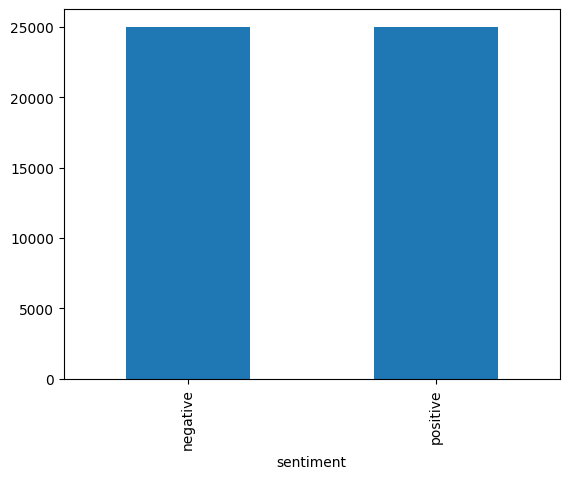

In [ ]:
# Visualize the postive and negative sentiments
movie_reviews.groupby("sentiment").sentiment.count().plot.bar(ylim=0);

In [ ]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

### Data Preprocessing

Remove html tags, non alphabet (punctuations and numbers), stop words,  and lower case all of the reviews from the review text data

In [ ]:
# Data Preprocessing
def preprocess_text(sen):

    sen = re.sub('<.*?>', ' ', sen) # remove html tag

    tokens = word_tokenize(sen)  # tokenizing words

    tokens = [w.lower() for w in tokens]    # lower case

    table = str.maketrans('', '', string.punctuation)  # remove punctuations
    stripped = [w.translate(table) for w in tokens]

    words = [word for word in stripped if word.isalpha()]  # remove non alphabet
    stop_words = set(stopwords.words('english'))

    words = [w for w in words if not w in stop_words]   # remove stop words
    words = [w for w in words if len(w) > 2]  # Ignore words less than 2

    return words

In [ ]:
# Store the preprocessed reviews in a new list
review_lines = []
sentences = list(movie_reviews['review'])

In [ ]:
for sen in sentences:
    # Call the preprocess_text function on each sentence of the review text
    review_lines.append(preprocess_text(sen))

In [ ]:
# Check for the length of the preprocessed text
len(review_lines)

50000

In [ ]:
# Print the preprocessed text for the first review
print(review_lines[0])

['one', 'reviewers', 'mentioned', 'watching', 'episode', 'hooked', 'right', 'exactly', 'happened', 'first', 'thing', 'struck', 'brutality', 'unflinching', 'scenes', 'violence', 'set', 'right', 'word', 'trust', 'show', 'faint', 'hearted', 'timid', 'show', 'pulls', 'punches', 'regards', 'drugs', 'sex', 'violence', 'hardcore', 'classic', 'use', 'word', 'called', 'nickname', 'given', 'oswald', 'maximum', 'security', 'state', 'penitentary', 'focuses', 'mainly', 'emerald', 'city', 'experimental', 'section', 'prison', 'cells', 'glass', 'fronts', 'face', 'inwards', 'privacy', 'high', 'agenda', 'city', 'home', 'many', 'aryans', 'muslims', 'gangstas', 'latinos', 'christians', 'italians', 'irish', 'scuffles', 'death', 'stares', 'dodgy', 'dealings', 'shady', 'agreements', 'never', 'far', 'away', 'would', 'say', 'main', 'appeal', 'show', 'due', 'fact', 'goes', 'shows', 'would', 'dare', 'forget', 'pretty', 'pictures', 'painted', 'mainstream', 'audiences', 'forget', 'charm', 'forget', 'romance', 'mes

In [ ]:
# Now let’s convert the sentiment from string to a binary form of 1 and 0,
# where 1 is for ‘positive’ sentiment and 0 for ‘negative’.
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

### Word Embedding

While dealing with textual data, we need to convert it into numbers before feeding into any machine learning model, including neural networks. For simplicity words can be compared to categorical variables. We use one-hot encoding to convert categorical features into numbers. To do so, we create dummy features for each of the category and populate them with 0’s and 1's.

Similarly if we use one-hot encoding on words in textual data, we will have a dummy feature for each word, which means 10,000 features for a vocabulary of 10,000 words. This is not a feasible embedding approach as it demands large storage space for the word vectors and reduces model efficiency and no relation is captured between words.

**Word2Vec** is one of the most popular technique to learn word embeddings using shallow neural network. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. A word embedding is a learned representation for text where words that have the same meaning have a similar representation.


#### **Why do we need them?**

Consider the following similar sentences: **Have a good day** and **Have a great day**. They hardly have different meaning. If we construct an vocabulary (let’s call it V), it would have V = **{Have, a, good, great, day}**.

Now, let us create a one-hot encoded vector for each of these words in V. Length of our one-hot encoded vector would be equal to the size of V (=5). We would have a vector of zeros except for the element at the index representing the corresponding word in the vocabulary. That particular element would be one. The encodings below would explain this better.

Have = [1,0,0,0,0] ; a = [0,1,0,0,0] ; good = [0,0,1,0,0] ; great = [0,0,0,1,0] ; day = [0,0,0,0,1]

If we try to visualize these encodings, we can think of a 5 dimensional space, where each word occupies one of the dimensions and has nothing to do with the rest (no projection along the other dimensions). This means ‘good’ and ‘great’ are as different as ‘day’ and ‘have’, which is not true.

Our objective is to have words with similar context occupy close spatial positions. Mathematically, the **cosine** of the angle between such vectors should be close to 1, i.e. angle close to 0. Higher the cosine similarity, the words are more closer


**Cosie Similarity**

$sim(A, B) = cos(\theta) = \frac{\bar{A}. \bar{B}}{\bar{|A|}\bar{|B|}}$


<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/Word_Embedding.png" width="550" height="350">
</center>

**Word2vec** model has 2 algorithms:

1. Continuous bag of word (CBOW)
2. Skip-gram

**Continuous bag of word (CBOW):**

CBOW predicts the target words from the surrounding context words.

**Eg: Context word:** "The cat sits on the ..",  **Target word:** "mat"

**Skip-gram:**

Skip-gram predicts surrounding context words from the target words

**Eg: Context word:** "The cat ... on the mat",  **Target word:** "sat"

**Note:** For more details of word2vec model refer to the following [link](https://medium.com/@zafaralibagh6/a-simple-word2vec-tutorial-61e64e38a6a1)




### Train word2vec Embedding

Here we calculate the word vectors before hand to use it in the network.

In Keras, this part is usually handled by an **Embedding layer** whuch enables us to convert each word into a fixed length vector of defined size. The resultant vector is a dense one with having real values instead of just 0’s and 1’s. The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions. This way embedding layer works like a lookup table. The words are the keys in this table, while the dense word vectors are the values.

Instead of training the embedding layer, we can first separately learn word embeddings and then pass to the embedding layer.

We will use Gensim to  implement the Word2Vec. **Gensim** is an open source Python library for natural language processing. It is developed and is maintained by the Czech natural language processing researcher Radim Řehůřek and his company RaRe Technologies. Here, the first step is to prepare the text corpus for learning the embedding by creating word tokens, removing punctuation, removing stop words etc. The word2vec algorithm processes documents sentence by sentence.

**Note:** Refer to the following [link](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for the parameters of gensim.models.Word2Vec

In [ ]:
EMBEDDING_DIM = 100

# Train word2vec model after preprocessing the reviews
model = gensim.models.Word2Vec(sentences=review_lines, vector_size=EMBEDDING_DIM, window=5, workers=4, min_count=1)

In [ ]:
print(model)

Word2Vec<vocab=132706, vector_size=100, alpha=0.025>


In [ ]:
words = list(model.wv.index_to_key)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 132706


**sentences** – List of sentences; here we pass the list of review sentences.

**size** – The number of dimensions in which we want to represent our word. This is the size of the word vector which instructs the Word2Vec() method to create a vector size of 100

**min_count** – Word with frequency greater than min_count only are going to be included into the model. Usually, the bigger and more extensive your text, the higher this number can be.

**window** – Only terms that occur within a window-neighborhood of a term, in a sentence, are associated with it during training. The usual value is 4 or 5.

**workers** – Number of threads used in training parallelization, to speed up training.

### Test Word2Vec Model

After we train the model on our IMDb dataset, it builds a vocabulary size = 133617 . Let us try some word embeddings the model learnt from the movie review dataset.

The most similar words for word horrible are:





In [ ]:
model.wv.most_similar('horrible')

[('terrible', 0.9227042198181152),
 ('awful', 0.88029944896698),
 ('horrendous', 0.8090967535972595),
 ('sucks', 0.8024343848228455),
 ('atrocious', 0.8003818988800049),
 ('pathetic', 0.7853007912635803),
 ('horrid', 0.779602587223053),
 ('dreadful', 0.7678539752960205),
 ('lousy', 0.7504919171333313),
 ('abysmal', 0.7333194017410278)]

Analogy on the word vectors — woman + king - man = ?

In [ ]:
# Find the top-N most similar words, using the multiplicative combination
# Let's see the result of semantically reasonable word vectors (king - man + woman)
model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('romeo', 0.8505546450614929),
 ('boon', 0.8463166356086731),
 ('winckler', 0.8372746109962463),
 ('princess', 0.829688310623169),
 ('commemorating', 0.8195465207099915),
 ('thrower', 0.818290114402771),
 ('sculptorneighbor', 0.8156214952468872),
 ('queen', 0.8127556443214417),
 ('flaxen', 0.812374472618103),
 ('tromeo', 0.8117942214012146)]

Let us find the odd word woman, king, queen, movie = ?


In [ ]:
print(model.wv.doesnt_match("woman king queen movie".split()))

movie


It's interesting to see the word embeddings learned by our word2vec model form the text corpus. The next step is to use the word embeddings directly in the embedding layer in our sentiment classification model. we can save the model to be used later.

In [ ]:
# Save model
filename = "imdb_embedding_word2vec.txt"
model.wv.save_word2vec_format(filename, binary=False)

### Use Pre-trained Embedding Matrix

Since we have already trained word2vec model with IMDb dataset, we have the word embeddings ready to use. The next step is to load the word embedding as a directory of words to vectors. The word embedding was saved in file imdb_embedding_word2vec.txt. Let us extract the word embeddings from the stored file. We defined the embedding matrix here, where all the words which are not in the word2vec dictionary being assigned a zero vector.

In [ ]:
import os

embeddings_index = {}
f = open(os.path.join('','imdb_embedding_word2vec.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

The next step is to convert the word embedding into tokenized vector. The review documents should be integer encoded prior to passing them to the Embedding layer. The integer maps to the index of a specific vector in the embedding layer. Therefore, it is important that we lay the vectors out in the Embedding layer such that the encoded words map to the correct vector.

### Tokenize and Pad sequences

A Neural Network only accepts numeric data, so we need to encode the reviews. Here use keras.Tokenizer() to encode the reviews into integers, where each unique word is automatically indexed (using `fit_on_texts` method) calculates the frequency of each word in our corpus/messages.

`texts_to_sequences` method finally converts our array of sequences of strings to list of sequences of integers (most frequent word is assigned 1 and so on).

Each reviews has a different length, so we need to add padding (by adding 0) or truncating the words to the same length (in this case, it is the mean of all reviews length) using `keras.preprocessing.sequence.pad_sequences.`

`post`, pad or truncate the words in the back of a sentence
`pre`, pad or truncate the words in front of a sentence

Each word is assigned an integer and that integer is placed in a list.


For example if we have a sentence “How text to sequence and padding works”. Each word is assigned a number. We suppose how = 1, text = 2, to = 3, sequence = 4, and = 5, padding = 6, works = 7. After texts_to_sequences is called our sentence will look like [1, 2, 3, 4, 5, 6, 7 ]. Now we suppose our MAX_SEQUENCE_LENGTH = 10. After padding our sentence will look like `pre` = [0, 0, 0, 1, 2, 3, 4, 5, 6, 7 ], `post` = [1, 2, 3, 4, 5, 6, 7, 0, 0, 0]

In [ ]:
# Tokenizer class from the keras.preprocessing.text module creates a word-to-index integer dictionary
# Vectorize the text samples
tokenizer = Tokenizer()
tokenizer.fit_on_texts(review_lines)
sequences = tokenizer.texts_to_sequences(review_lines)

In [ ]:
# Pad sequences
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

# Only consider the first  100 words of each movie review
max_length = 100

review_pad = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
sentiment = y

print('Shape of pad tensor:', review_pad.shape)
print('Shape of sentiment tensor', sentiment.shape)

Found 132706 unique tokens
Shape of pad tensor: (50000, 100)
Shape of sentiment tensor (50000,)


The review_pad set contains 50,000 lists of integers, each list corresponding to the sentences in a review. Set the maximum length of each list to 100 and add 0 padding to those lists that have a length < 100, until they reach a length of 100

In [ ]:
print(word_index)

{'movie': 1, 'film': 2, 'one': 3, 'like': 4, 'good': 5, 'would': 6, 'even': 7, 'time': 8, 'really': 9, 'story': 10, 'see': 11, 'well': 12, 'much': 13, 'could': 14, 'get': 15, 'bad': 16, 'people': 17, 'great': 18, 'also': 19, 'first': 20, 'made': 21, 'way': 22, 'make': 23, 'movies': 24, 'characters': 25, 'think': 26, 'watch': 27, 'character': 28, 'films': 29, 'many': 30, 'seen': 31, 'two': 32, 'never': 33, 'love': 34, 'acting': 35, 'plot': 36, 'show': 37, 'best': 38, 'know': 39, 'little': 40, 'life': 41, 'ever': 42, 'better': 43, 'man': 44, 'end': 45, 'scene': 46, 'still': 47, 'say': 48, 'scenes': 49, 'something': 50, 'back': 51, 'thing': 52, 'watching': 53, 'real': 54, 'actors': 55, 'though': 56, 'years': 57, 'funny': 58, 'another': 59, 'actually': 60, 'nothing': 61, 'makes': 62, 'work': 63, 'find': 64, 'look': 65, 'director': 66, 'going': 67, 'lot': 68, 'new': 69, 'every': 70, 'old': 71, 'part': 72, 'cast': 73, 'things': 74, 'world': 75, 'want': 76, 'quite': 77, 'got': 78, 'pretty': 7

word_index attribute from Tokenizer class is a dictionary keeping track of word to their index/integer representation as calculated by fit_on_texts method.

In [ ]:
# Padded reviews
print(review_pad)

[[    3  1821   901 ...   661   723   776]
 [  260    40   237 ...     0     0     0]
 [   89   260    22 ...     0     0     0]
 ...
 [ 3271  4098 38793 ...  4455    34    17]
 [   67  2762   748 ...  3124 18410 12151]
 [    3  5520   218 ...     0     0     0]]


Now we will map embeddings from the loaded word2vec model for each word to the tokenizer.word_index vocabulary and create a matrix with of word vectors.

In [ ]:
# Adding 1 because of reversed 0 index
vocab_size = len(word_index) + 1

# Create a weight matrix for words in the training data
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, index in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # If words not found in embedding matrix will be all 0's
    embedding_matrix[index, :] = embedding_vector

In [ ]:
print(vocab_size)

132707


### Long Short-Term Memory units (LSTM Cell)

![Img](https://cdn.iisc.talentsprint.com/CDS/Images/LSTM_Cell.PNG)

$\text{Figure:  LSTM-Cell }$

### Understanding Gates and States


**Forget gate** (Controlled by $f_{(t)}$) controls which parts of the long-term state should be erased.

**Input gate** (controlled by :  $i_{(t)}$) controls which parts of a  $g_{(t)}$ should be added to the long term cell state  $c_{(t)}$.

**Output gate** (controlled by $o_{(t)}$) controls which parts of the long term cell state should be read and output at this time step, both to prediction $y_{(t)}$  and $h_{(t)}$.

**Long term Cell state**  $c_{(t)}$ is the "memory" that gets passed onto future time steps.

 **Short term Cell state** $h_{(t)}$

* The Short term state gets passed to the LSTM cell's next time step.
* It is used to determine the three gates (Controlled by $f_{(t)}$, $i_{(t)}$, $o_{(t)}$) of the next time step.
* It is also used for the prediction $y_{(t)}$.

**Embedding Layer:**  it creates word vectors of each word in the word_index and group words that are related or have similar meaning by analyzing other words around them.

**LSTM Layer:** Deep network takes the sequence of embedding vectors as input and converts them to a compressed representation. The compressed representation effectively captures all the information in the sequence of words in the text.

**Dense Layer:** The fully connected layer takes the deep representation from the LSTM and transforms it into the final output classes or class scores (using sigmoid activation function).






#### Build LSTM Model for Text Classification

We are now ready with the trained embedding vector to be used directly in the embedding layer. In the below code, we use the embedding_matrix as input to the Embedding layer and setting trainable = False, since the embedding is already learned.

In [ ]:
EMBEDDING_DIM = 100

# Define Model
model = Sequential()
embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          13270700  
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 13287757 (50.69 MB)
Trainable params: 17057 (66.63 KB)
Non-trainable params: 13270700 (50.62 MB)
_________________________________________________________________
None


In [ ]:
# Try using different optimizers and different optimizer configs
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

To train the sentiment classification model, we use test_split= 0.2, you can vary this to see effect on the accuracy of the model.

### Split the data into train and test sets

In [ ]:
test_split = 0.2

indices = np.arange(review_pad.shape[0])

review_pad = review_pad[indices]
sentiment = sentiment[indices]

num_test_samples = int(test_split * review_pad.shape[0])

X_train_pad = review_pad[:-num_test_samples]
y_train = sentiment[:-num_test_samples]
X_test_pad = review_pad[-num_test_samples:]
y_test = sentiment[-num_test_samples:]

In [ ]:
X_train_pad.shape, y_train.shape, X_test_pad.shape, y_test.shape

((40000, 100), (40000,), (10000, 100), (10000,))

In [ ]:
X_train_pad

array([[   3, 1821,  901, ...,  661,  723,  776],
       [ 260,   40,  237, ...,    0,    0,    0],
       [  89,  260,   22, ...,    0,    0,    0],
       ...,
       [  37,  976,   34, ...,    0,    0,    0],
       [  86,    1, 5003, ..., 2028,  101, 8399],
       [4667, 4640,  519, ..., 1390,  117, 1081]], dtype=int32)

### Training the model

In [ ]:
history = model.fit(X_train_pad, y_train, batch_size=128, verbose=1, epochs=5, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 49s 166ms/step - loss: 0.5439 - accuracy: 0.7358 - val_loss: 0.4885 - val_accuracy: 0.7954
Epoch 2/5
250/250 [==============================] - 42s 168ms/step - loss: 0.4688 - accuracy: 0.8049 - val_loss: 0.4455 - val_accuracy: 0.8234
Epoch 3/5
250/250 [==============================] - 40s 160ms/step - loss: 0.4064 - accuracy: 0.8303 - val_loss: 0.3840 - val_accuracy: 0.8425
Epoch 4/5
250/250 [==============================] - 43s 170ms/step - loss: 0.3729 - accuracy: 0.8382 - val_loss: 0.3732 - val_accuracy: 0.8382
Epoch 5/5
250/250 [==============================] - 39s 157ms/step - loss: 0.3535 - accuracy: 0.8498 - val_loss: 0.3719 - val_accuracy: 0.8499


### Visualization of Training and Validation Accuracy

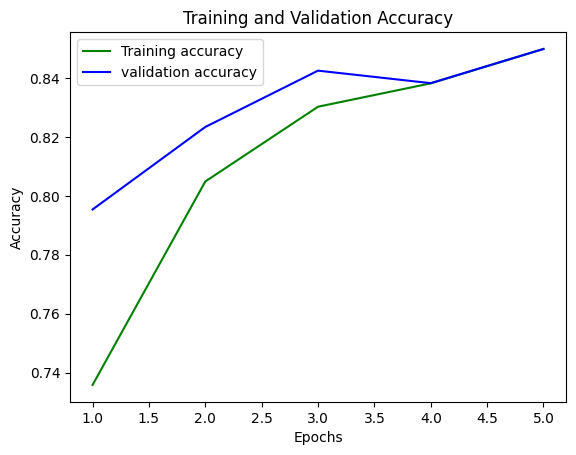

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,6)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Testing the Model

In [ ]:
print('Testing...')
model.evaluate(X_test_pad, y_test)

Testing...
313/313 [==============================] - 9s 29ms/step - loss: 0.3594 - accuracy: 0.8554


[0.3594355583190918, 0.855400025844574]

### Get the predictions using trained LSTM model


In [ ]:
# model predictions on the test data
preds = model.predict(X_test_pad)
n = np.random.randint(0, 9999)

# Predictions (set the threshold as 0.5)
if preds[n] > 0.5:
  print('predicted sentiment : positive')
else:
  print('precicted sentiment : negative')

# Original Labels
if (y_test[n] == 1):
  print('correct sentiment : positive')
else:
  print('correct sentiment : negative')

313/313 [==============================] - 10s 31ms/step
predicted sentiment : positive
correct sentiment : positive


In [ ]:
# Get the text sequences for the preprocessed movie reviews
reviews_list_idx = tokenizer.texts_to_sequences(review_lines)

In [ ]:
print(reviews_list_idx[1])

[260, 40, 237, 1181, 2724, 17242, 67775, 1409, 274, 12754, 383, 25432, 163, 1657, 306, 281, 55, 412, 12, 2092, 353, 3922, 78, 67776, 2045, 3002, 240, 11, 12995, 639, 9461, 1608, 1514, 6964, 6289, 12, 157, 53, 36796, 308, 2166, 281, 4043, 237, 3, 18, 980, 101, 41, 1657, 9, 149, 221, 40, 74, 894, 2708, 133, 229, 1983, 840, 2866, 1080, 992, 4613, 177, 1609, 4245, 430, 49, 3390, 18645, 24363, 564, 430, 914, 24363, 45318, 26684, 70, 2059, 1739, 12, 113]


In [ ]:
# Function to get the predictions on the movie reviews using LSTM model
def add_score_predictions(data, reviews_list_idx):

  # Pad the sequences of the data
  reviews_list_idx = pad_sequences(reviews_list_idx, maxlen=max_length, padding='post', truncating='post')

  # Get the predictons by using LSTM model
  review_preds = model.predict(reviews_list_idx)

  # Add the predictions to the movie reviews data
  movie_reviews['sentiment score'] = review_preds

  # Set the threshold for the predictions
  pred_sentiment = np.array(list(map(lambda x : 'positive' if x > 0.5 else 'negative',review_preds)))

  # Add the sentiment predictions to the movie reviews
  movie_reviews['predicted sentiment'] = pred_sentiment

  return movie_reviews

In [ ]:
# Call the above function to get the sentiment score and the predicted sentiment
data = add_score_predictions(movie_reviews, reviews_list_idx)

1563/1563 [==============================] - 50s 32ms/step


In [ ]:
# Display the data
data[:20]

,review,sentiment,sentiment score,predicted sentiment
0,One of the other reviewers has mentioned that ...,positive,0.416076,negative
1,A wonderful little production. <br /><br />The...,positive,0.961076,positive
2,I thought this was a wonderful way to spend ti...,positive,0.961694,positive
3,Basically there's a family where a little boy ...,negative,0.022004,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.965498,positive
5,"Probably my all-time favorite movie, a story o...",positive,0.957101,positive
6,I sure would like to see a resurrection of a u...,positive,0.355455,negative
7,"This show was an amazing, fresh & innovative i...",negative,0.138237,negative
8,Encouraged by the positive comments about this...,negative,0.021550,negative
9,If you like original gut wrenching laughter yo...,positive,0.950860,positive


### BI-LSTM(Bi-directional long short term memory)

Bidirectional long-short term memory(bi-lstm) is the process of making any neural network to have the sequence information in both directions backwards (future to past) or forward (past to future).

In bidirectional, our input flows in two directions, making a bi-lstm different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve the future and the past information.     

For example: In the sentence “boys go to …..” we can not fill the blank space. Still, when we have a future sentence “boys come out of school”, we can easily predict the past blank space the similar thing we want to perform by our model and bidirectional LSTM allows the neural network to perform this.
<br><br>
<center>
<img src="https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/BI-LSTM.jpeg" width="500" height="350">
</center>

In the above diagram, we can see the flow of information from backward and forward layers. BI-LSTM is usually employed where the sequence to sequence tasks are needed. This kind of network can be used in text classification, speech recognition and forecasting

### Train Bi-directional LSTM model

In [ ]:
model2 = Sequential()

# Define Model
embedding_layer = Embedding(vocab_size,
                            EMBEDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable=False)
model2.add(embedding_layer)
model2.add(Bidirectional(LSTM(64, recurrent_dropout=0.6)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
print('Summary of the built model...')
print(model2.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          13270700  
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13355309 (50.95 MB)
Trainable params: 84609 (330.50 KB)
Non-trainable params: 13270700 (50.62 MB)
_________________________________________________________________
None


In [ ]:
# Train the Bidirectional LSTM model
history2 = model2.fit(X_train_pad, y_train, batch_size=128, verbose=1, epochs=5, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 88s 309ms/step - loss: 0.4283 - accuracy: 0.7997 - val_loss: 0.3646 - val_accuracy: 0.8451
Epoch 2/5
250/250 [==============================] - 71s 284ms/step - loss: 0.3394 - accuracy: 0.8568 - val_loss: 0.3451 - val_accuracy: 0.8524
Epoch 3/5
250/250 [==============================] - 69s 277ms/step - loss: 0.3180 - accuracy: 0.8681 - val_loss: 0.3194 - val_accuracy: 0.8600
Epoch 4/5
250/250 [==============================] - 67s 269ms/step - loss: 0.3024 - accuracy: 0.8758 - val_loss: 0.3261 - val_accuracy: 0.8625
Epoch 5/5
250/250 [==============================] - 71s 285ms/step - loss: 0.2910 - accuracy: 0.8788 - val_loss: 0.3156 - val_accuracy: 0.8661


In [ ]:
# Evaluate the trained model on test data
print('Testing...')
model2.evaluate(X_test_pad, y_test)

Testing...
313/313 [==============================] - 19s 60ms/step - loss: 0.3105 - accuracy: 0.8722


[0.31050345301628113, 0.8722000122070312]

In [ ]:
# Let us test some samples using Bi-directional LSTMs
test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "Not to my taste, will skip and watch another movie"
test_sample_5 = "if you don't like action, then this movie might be bad for you."
test_sample_6 = "Bad movie!"
test_sample_7 = "This movie really sucks! Can I get my money back please?"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7]

for each in test_samples:
  filtered = [preprocess_text(each)]
  tokenize_words = tokenizer.texts_to_sequences(filtered)
  tokenize_words = pad_sequences(tokenize_words, maxlen=max_length, padding='post', truncating='post')
  result = model2.predict(tokenize_words)

  if result >= 0.5:
      print('positive == ',each)
  else:
      print('negative == ',each)

1/1 [==============================] - 1s 743ms/step
positive ==  This movie is fantastic! I really like it because it is so good!
1/1 [==============================] - 0s 127ms/step
positive ==  Good movie!
1/1 [==============================] - 0s 143ms/step
negative ==  Maybe I like this movie.
1/1 [==============================] - 0s 189ms/step
negative ==  Not to my taste, will skip and watch another movie
1/1 [==============================] - 0s 149ms/step
negative ==  if you don't like action, then this movie might be bad for you.
1/1 [==============================] - 0s 130ms/step
negative ==  Bad movie!
1/1 [==============================] - 0s 146ms/step
negative ==  This movie really sucks! Can I get my money back please?
